# Gaussian Mixture Model

This is tutorial demonstrates how to marginalize out discrete latent variables in Pyro through the motivating example of a mixture model. We'll focus on the mechanics of parallel enumeration, keeping the model simple by training a trivial 1-D Gaussian model on a tiny 5-point dataset.

Pyro's [`TraceEnum_ELBO`](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.TraceEnum_ELBO) can automatically marginalize out variables in both the guide and the model. When enumerating guide variables, Pyro can either enumerate sequentially (which is useful if the variables determine downstream control flow), or enumerate in parallel by allocating a new tensor dimension and using nonstandard evaluation to create a tensor of possible values at the variable's sample site. These nonstandard values are then replayed in the model. When enumerating variables in the model, the variables must be enumerated in parallel and must not appear in the guide. Mathematically, guide-side enumeration simply reduces variance in a stochastic ELBO by enumerating all values, whereas model-side enumeration avoids an application of Jensen's inequality by exactly marginalizing out a variable.

In [1]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate

smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

## Dataset

Here is our tiny dataset. It has five points.

In [2]:
data = torch.tensor([0., 1., 10., 11., 12.])

## MAP estimation

Let's start by learning model parameters `weights`, `locs`, and `scale` given priors and data. We will learn point estimates of these using an [`AutoDelta`](http://docs.pyro.ai/en/dev/contrib.autoguide.html#autodelta) guide (named after its delta distributions). Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. During inference, [`TraceEnum_ELBO`](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.traceenum_elbo.TraceEnum_ELBO) will marginalize out the assignments of datapoints to clusters.

In [3]:
K = 2  # Fixed number of components.

@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.iarange('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.iarange('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']))

To run inference with this `(model,guide)` pair, we use Pyro's [`config_enumerate()`](http://docs.pyro.ai/en/dev/poutine.html#pyro.infer.enum.config_enumerate) function to enumerate over all assignments in each iteration. Since we've wrapped the batched Categorical assignments in a [`pyro.iarange`](http://docs.pyro.ai/en/dev/primitives.html#pyro.iarange) indepencence context, this enumeration can happen in parallel: we enumerate only 2 possibilites, rather than `2**len(data) = 32`. Finally, to use the parallel version of enumeration, we inform Pyro that we're only using a single [`iarange`](http://docs.pyro.ai/en/dev/primitives.html#pyro.iarange) via `max_iarange_nesting=1`; this lets Pyro know that we're using the rightmost dimension [`iarange`](http://docs.pyro.ai/en/dev/primitives.html#pyro.iarange) and that Pyro can use any other dimension for parallelization.

In [4]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)

Before inference we'll initialize to plausible values. Mixture models are very succeptible to local modes. A common approach is choose the best among many randomly initializations, where the cluster means are initialized from random subsamples of the data. Since we're using an [`AutoDelta`](http://docs.pyro.ai/en/dev/contrib.autoguide.html#autodelta) guide, we can initialize one param for each variable, where the name is prefixed by "auto_" and the constraint is appropriate for each distribution (you can find constraint from the [`Distribution.support`](https://pytorch.org/docs/stable/distributions.html#torch.distributions.distribution.Distribution.support) attribute).

In [5]:
def initialize(seed):
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    # Initialize weights to uniform.
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)
    # Assume half of the data variance is due to intra-component noise.
    pyro.param('auto_scale', (data.var() / 2).sqrt(), constraint=constraints.positive)
    # Initialize means from a subsample of data.
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)]);
    loss = svi.loss(model, global_guide, data)
    return loss

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 7, initial_loss = 25.6655845642


During training, we'll collect both losses and gradient norms to monitor convergence. We can do this using PyTorch's `.register_hook()` method.

In [6]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

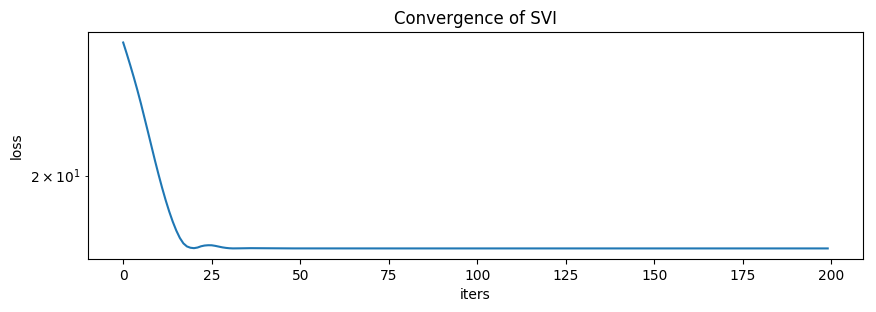

In [7]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

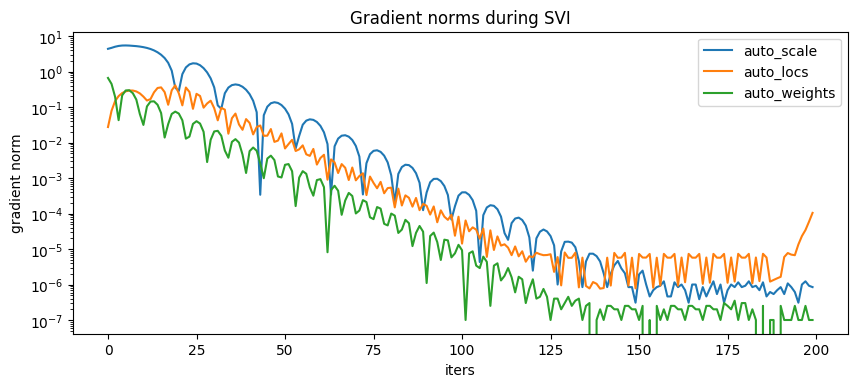

In [8]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

Here are the learned parameters:

In [9]:
map_estimates = global_guide(data)
weights = map_estimates['weights']
locs = map_estimates['locs']
scale = map_estimates['scale']
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.375      0.62500006]
locs = [ 0.49898112 10.984461  ]
scale = 0.651433706284


The model's `weights` are as expected, with about 2/5 of the data in the first component and 3/5 in the second component. Next let's visualize the mixture model.

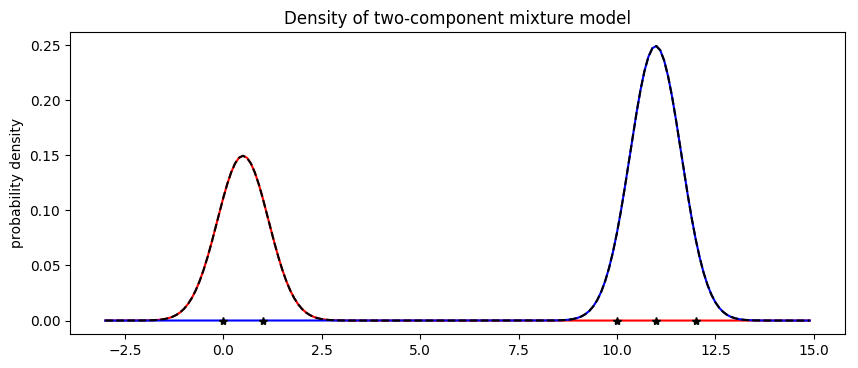

In [10]:
X = np.arange(-3,15,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(10, 4), dpi=100).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Density of two-component mixture model')
pyplot.ylabel('probability density');

Finally note that optimization with mixture models is non-convex and can often get stuck in local optima. For example in this tutorial, we observed that the mixture model gets stuck in an everthing-in-one-cluster hypothesis if `scale` is initialized to be too large.

## Enumerating in the Guide: predicting membership

So far we've marginalized out the assignment variables in the model. While this provides fast convergence, it prevents us from reading the cluster assignments from the guide.

To read cluster assignemnts from the guide, we'll define a new `full_guide` that fits both global parameters (as above) and local parameters (which were previously marginalized out). Since we've already learned good values for globals, we'll prevent SVI from updating those by using [`poutine.block`](http://docs.pyro.ai/en/dev/poutine.html#pyro.poutine.block).

In [11]:
@config_enumerate(default="parallel")
@poutine.broadcast
def full_guide(data):
    # Global variables.
    with poutine.block(hide_types=["param"]):  # Keep our learned values of global parameters.
        global_guide(data)

    # Local variables.
    with pyro.iarange('data', len(data)):
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data), K) / K,
                                      constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Categorical(assignment_probs))

In [12]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_iarange_nesting=1)
svi = SVI(model, full_guide, optim, loss=elbo)

# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
svi.loss(model, full_guide, data)  # Initializes param store.
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................

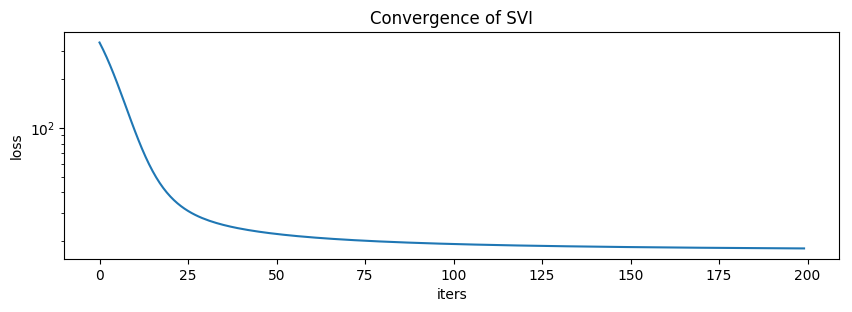

In [13]:
pyplot.figure(figsize=(10,3), dpi=100).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI');

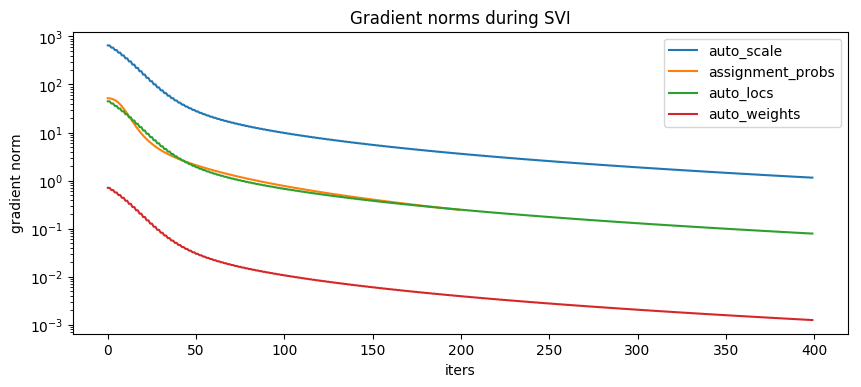

In [14]:
pyplot.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    pyplot.plot(grad_norms, label=name)
pyplot.xlabel('iters')
pyplot.ylabel('gradient norm')
pyplot.yscale('log')
pyplot.legend(loc='best')
pyplot.title('Gradient norms during SVI');

We can now examine the guide's local `assignment_probs` variable.

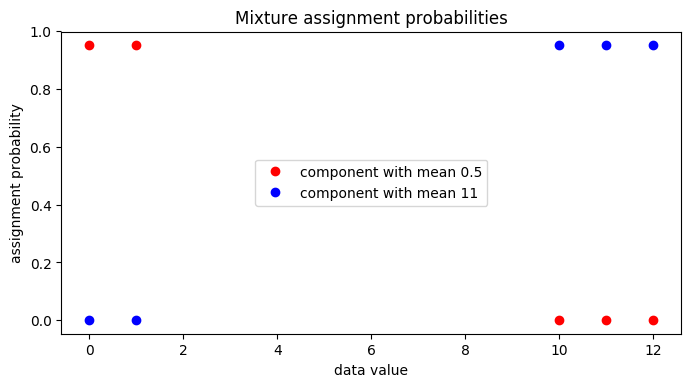

In [15]:
assignment_probs = pyro.param('assignment_probs')
pyplot.figure(figsize=(8, 4), dpi=100).set_facecolor('white')
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
            label='component with mean {:0.2g}'.format(locs[0]))
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
            label='component with mean {:0.2g}'.format(locs[1]))
pyplot.title('Mixture assignment probabilities')
pyplot.xlabel('data value')
pyplot.ylabel('assignment probability')
pyplot.legend(loc='center');